In [1]:
import os
import pickle

from jasyntho import SynthTree
from jasyntho.extract import ExtractReaction


async def extract_tree(
    path, model="gpt-3.5-turbo", method="text", si_select=False
):
    tree = SynthTree.from_dir(path)
    tree.rxn_extract = ExtractReaction(llm=model)

    tree.raw_prods = await tree.async_extract_rss(
        mode=method, si_select=si_select
    )
    tree.products = [p for p in tree.raw_prods if not p.isempty()]

    reach_sgs = tree.partition()
    return tree

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load ground truth graph
import networkx as nx

path = "../benchmark/papers/ja074300t"
with open(os.path.join(path, "gt_graph.pickle"), "rb") as f:
    gt_G = pickle.load(f)

In [3]:
# Extract a graph from paper

# tree = await extract_tree(path, model='gpt-3.5-turbo', method='vision')
# extracted_G = tree.full_g

# with open(os.path.join(path, 'extracted_graph_gpt35_vision.pickle'), 'wb') as f:
#     pickle.dump(extracted_G, f)

with open(
    os.path.join(path, "extracted_graph_gpt35_vision.pickle"), "rb"
) as f:
    extracted_G = pickle.load(f)

# Ways of comparing the two graphs

- Graph Edit Distance  # very slow
- Subgraph matching
- Spectral analysis
- Edge overlap

In [4]:
# sorts of subgraph matching


# Find subgraphs of extracted graph, and compare with ground truth graph
def find_subgraphs_larger_than_n(G, N):
    subgraphs = []

    # Find all connected components (subgraphs) in the graph
    connected_subgraphs = nx.connected_components(G)

    # Iterate over each connected subgraph
    for subgraph_nodes in connected_subgraphs:

        # Check if the size of the subgraph is greater than N
        if len(subgraph_nodes) > N:
            # Create a subgraph from the nodes
            subgraph = G.subgraph(subgraph_nodes)
            subgraphs.append(subgraph)

    return subgraphs


# Find subgraphs of size greater than 3
N = 3
subg_3 = find_subgraphs_larger_than_n(extracted_G.to_undirected(), N)


def subgraph_in_gt(subgraph, gt_G):
    # Check if the subgraph is present in the host graph
    matcher = nx.algorithms.isomorphism.GraphMatcher(gt_G, subgraph)
    is_match = matcher.subgraph_is_isomorphic()

    if is_match:
        print("The subgraph is present in the host graph.")
        # Get the mapping of nodes between the subgraph and the host graph
        mapping = matcher.mapping
        print("Mapping:", mapping)
    else:
        print("The subgraph is not present in the host graph.")


# for subgraph in subg_3:
#     subgraph_in_gt(subgraph, gt_G.to_undirected())

In [5]:
# Compare the immediate neighborhood of the nodes. e.g. is the local structure preserved?


def get_neighborhood_subgraph(G, node):
    # Get the incoming and outgoing neighbors of the node
    in_neighbors = [edge[0] for edge in G.in_edges(node)]
    out_neighbors = [edge[1] for edge in G.out_edges(node)]
    neighbors = set(in_neighbors + out_neighbors + [node])
    subgraph = G.subgraph(neighbors)
    return subgraph


def subgraph_in_gt_exact(subgraph, gt_G):
    """Check if the subgraph is present in the host graph."""
    subg_gt = gt_G.subgraph(subgraph.nodes)
    if len(subg_gt) == len(subgraph):
        return True
    return False


def subgraph_in_gt_isomorphic(subgraph, gt_G):
    matcher = nx.algorithms.isomorphism.GraphMatcher(gt_G, subgraph)
    is_match = matcher.subgraph_is_isomorphic()
    return is_match


def compare_local_exact_0(G, gt_G):
    quant = []
    for node in G.nodes:
        sg = get_neighborhood_subgraph(G, node)
        if len(sg) > 1:
            v = subgraph_in_gt_exact(sg, gt_G)
            quant.append(v)
    return (sum(quant)+1) / (len(quant)+1)


def compare_local_exact(gt_G, G):
    c1 = compare_local_exact_0(gt_G, G)
    c2 = compare_local_exact_0(G, gt_G)
    return c1, c2


def compare_local_iso(G, gt_G):
    quant = []
    for node in G.nodes:
        sg = get_neighborhood_subgraph(G, node)
        if len(sg) > 1:
            v = subgraph_in_gt_isomorphic(sg, gt_G)
            quant.append(v)
    return (sum(quant)+1) / (len(quant)+1)

In [6]:
print(compare_local_exact(gt_G, gt_G))
print(compare_local_exact(gt_G, extracted_G))

# Compare with other syntheses
path2 = "../benchmark/papers/jacs.0c00308"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_local_exact(other_G, gt_G))
path2 = "../benchmark/papers/jacs.0c00363"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_local_exact(other_G, gt_G))

(1.0, 1.0)
(0.05154639175257732, 0.2191780821917808)
(0.015625, 0.005154639175257732)
(0.023529411764705882, 0.010309278350515464)


In [7]:
# Similar thing, but with paths (testing more long-range structure)


def get_paths(G):
    paths = []
    for n0 in G.nodes:
        for n1 in G.nodes:
            if n0 != n1:
                if nx.has_path(G, n0, n1):
                    ps = nx.all_simple_paths(G, source=n0, target=n1)
                    paths += list(ps)
    return paths


def compare_path_exact_0(G, gt_G):
    """How many paths in G are also in gt_G"""
    quant = []
    subgraphs = get_paths(G)
    for path in subgraphs:
        if len(path) > 1:
            sg = G.subgraph(path)
            v = subgraph_in_gt_exact(sg, gt_G)
            quant.append(v)
    return (sum(quant)+1) / (len(quant)+1)


def compare_path_exact(gt_G, G):
    # gt_G in G
    c0 = compare_path_exact_0(gt_G, G)
    # G in gt_G
    c1 = compare_path_exact_0(G, gt_G)
    return c0, c1


print(compare_path_exact(gt_G, gt_G))
print(compare_path_exact(gt_G, extracted_G))

# Compare with other syntheses
path2 = "../benchmark/papers/jacs.0c00308"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact(gt_G, other_G))
path2 = "../benchmark/papers/jacs.0c00363"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact(gt_G, other_G))

(1.0, 1.0)
(0.10898543569489015, 0.313458262350937)
(0.00012342631449024932, 0.0005257623554153522)
(0.0004937052579609973, 0.0040137614678899085)


In [8]:
# TODO next: compare routes extracted with different methods! see if they make sense


async def extractg(
    path, model="gpt-3.5-turbo", method="text", si_select=False
):

    tree = await extract_tree(
        path, model=model, method=method, si_select=si_select
    )
    extracted_G = tree.full_g

    if model == "gpt-3.5-turbo":
        k = "gpt35"
    elif model == "gpt-4-turbo":
        k = "gpt4t"
    elif model == "gpt-4":
        k = "gpt4"
    elif model == "gpt-4o":
        k = "gpt4o"

    if si_select:
        si = "select"
    else:
        si = ""

    with open(
        os.path.join(path, f"extracted_graph_{k}_{method}_{si}.pickle"), "wb"
    ) as f:
        pickle.dump(extracted_G, f)

    return extracted_G

In [9]:
# eg = await extractg(path, model="gpt-3.5-turbo", method="text", si_select=True)
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(path, model="gpt-4-turbo", method="text", si_select=True)
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(
#     path, model="gpt-3.5-turbo", method="vision", si_select=True
# )
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(path, model="gpt-4-turbo", method="vision", si_select=True)
# print(compare_path_exact(eg, gt_G))

In [10]:
for method in ["text", "vision"]:
    for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
        for si_select in [True, False]:

            if model == "gpt-3.5-turbo":
                k = "gpt35"
            elif model == "gpt-4-turbo":
                k = "gpt4t"
            elif model == "gpt-4":
                k = "gpt4"
            elif model == "gpt-4o":
                k = "gpt4o"

            if si_select:
                si = "_select"
            else:
                si = ""
            with open(
                os.path.join(path, f"extracted_graph_{k}_{method}{si}.pickle"),
                "rb",
            ) as f:
                og = pickle.load(f)
                print(k, method, si)
                print("Path:", compare_path_exact(gt_G, og))
                print("Local:", compare_local_exact(gt_G, og))

gpt35 text _select
Path: (0.15551715625771415, 0.5223367697594502)
Local: (0.32989690721649484, 0.3930635838150289)
gpt35 text 
Path: (0.18230066650209825, 0.5397350993377483)
Local: (0.35051546391752575, 0.41975308641975306)
gpt4t text _select
Path: (0.2387064922241422, 0.7892682926829269)
Local: (0.5463917525773195, 0.6022727272727273)
gpt4t text 
Path: (0.15761540360404838, 0.8093947606142728)
Local: (0.4742268041237113, 0.6363636363636364)
gpt35 vision _select
Path: (0.48432485805973835, 0.2379770400248216)
Local: (0.35051546391752575, 0.3125)
gpt35 vision 
Path: (0.10898543569489015, 0.313458262350937)
Local: (0.05154639175257732, 0.2191780821917808)
gpt4t vision _select
Path: (0.2577141446556406, 0.3267918088737201)
Local: (0.25257731958762886, 0.2883435582822086)
gpt4t vision 
Path: (0.15897309306344112, 0.5195530726256983)
Local: (0.25257731958762886, 0.3387096774193548)


In [21]:
# For all directories in benchmark, load the graphs with each method and compare with ground truth
import os
import pickle
def load_gr_graph(
    path, model="gpt-3.5-turbo", method="text", si_select=False
):
    if model == "gpt-3.5-turbo":
        k = "gpt35"
    elif model == "gpt-4-turbo":
        k = "gpt4t"
    elif model == "gpt-4":
        k = "gpt4"
    elif model == "gpt-4o":
        k = "gpt4o"

    if si_select:
        si = "select"
    else:
        si = ""

    with open(
        os.path.join(path, f"extracted_graph_{k}_{method}_{si}.pickle"),
        "rb",
    ) as f:
        exg = pickle.load(f)
    return exg


import pandas as pd

discarded = [
    'jacs.3c07019',
    'jacs.3c01991',
]
df = []

for paper in os.listdir("../benchmark/papers"):
    print(paper)
    if paper in discarded:
        continue
    path = os.path.join("../benchmark/papers", paper)
    if 'gt_graph.pickle' in os.listdir(path):
        with open(os.path.join(path, "gt_graph.pickle"), "rb") as f:
            gt = pickle.load(f)
    else:
        continue
        with open(os.path.join(path, "extracted_graph_gpt4t_vision_.pickle"), "rb") as f:
            gt = pickle.load(f)

    for method in ["vision", "text"]:
        for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
            for si_select in [True, False]:
                try:
                    og = load_gr_graph(path, model, method, si_select)
                    # if len(og)>1000:
                    #     print("Too large graph: ", paper, model, method, si_select)
                    #     continue
                except:
                    continue

                loc = compare_local_exact(gt, og)
                pat = compare_path_exact(gt, og)
                df.append({
                    "paper": paper,
                    "model": model,
                    "method": method,
                    "si_select": si_select,
                    "path_sim_in": pat[0],
                    "path_sim_out": pat[1],
                    "local_sim_in": loc[0],
                    "local_sim_out": loc[1],
                })


df = pd.DataFrame(df)

# 3c07019
df


jacs.2c06934
jacs.9b09699
jacs.7b11299
jacs.7b07724
jacs.7b00807
jacs.8b13029
jacs.3c01991
jacs.7b06055
jacs.0c00308
jacs.8b06755
jacs.2c12529
jacs.1c00293
jacs.9b05013
jacs.8b03015
jacs.7b09929
jacs.0c10122
jacs.2c13889
ja074300t
jacs.9b12546
jacs.3c07019
jacs.1c01356
jacs.0c00363
jacs.0c02513
jacs.7b01454
jacs.7b13260
jacs.8b00148
jacs.7b08749
jacs.6b07846
jacs.0c02143


,paper,model,method,si_select,path_sim_in,path_sim_out,local_sim_in,local_sim_out
0,jacs.7b00807,gpt-3.5-turbo,vision,True,0.076564,0.609375,0.281915,0.481250
1,jacs.7b00807,gpt-3.5-turbo,vision,False,0.050798,0.263352,0.074468,0.173267
2,jacs.7b00807,gpt-4-turbo,vision,True,0.156564,0.534202,0.143617,0.287671
3,jacs.7b00807,gpt-4-turbo,vision,False,0.112393,0.572979,0.132979,0.281081
4,jacs.7b00807,gpt-3.5-turbo,text,True,0.088589,0.550936,0.234043,0.360947
...,...,...,...,...,...,...,...,...
113,jacs.0c02143,gpt-4-turbo,vision,True,0.728643,0.423889,0.461538,0.294872
114,jacs.0c02143,gpt-4-turbo,vision,False,0.625126,0.711340,0.569231,0.590164
115,jacs.0c02143,gpt-3.5-turbo,text,True,0.367839,0.428571,0.292308,0.333333
116,jacs.0c02143,gpt-4-turbo,text,True,0.666332,0.594030,0.492308,0.405797


In [22]:
# Average score across papers

_vars = ['path_sim_in', 'path_sim_out', 'local_sim_in', 'local_sim_out']
df.groupby(['model', 'method', 'si_select'])[_vars].mean()

path_sim_in  path_sim_out  local_sim_in  \
model         method si_select                                            
gpt-3.5-turbo text   False         0.205259      0.536381      0.278485   
                     True          0.133876      0.492600      0.248409   
              vision False         0.291593      0.367757      0.277031   
                     True          0.287511      0.448821      0.295712   
gpt-4-turbo   text   False         0.597521      0.733390      0.572606   
                     True          0.486730      0.718383      0.474933   
              vision False         0.427596      0.511616      0.411504   
                     True          0.296307      0.526868      0.273053   

                                local_sim_out  
model         method si_select                 
gpt-3.5-turbo text   False           0.395829  
                     True            0.385851  
              vision False           0.249054  
                     True            0.336667  
gpt-4-turbo   text   False           0.591876  
                     True            0.568464  
              vision False           0.348778  
                     True            0.371352

In [23]:
# Visualize the results for all methods

import matplotlib.pyplot as plt
import seaborn as sns

# Create the hierarchical boxplot with custom figure size

def make_plot(metric):
    df_ = df.sort_values(by=['method', 'model'])

    g = sns.catplot(
        x='model',
        y=metric,
        hue='si_select',
        col='method',
        data=df_,
        # kind='box',
        height=6,
        aspect=0.5,
        palette='magma'
    )

    axes = g.axes.flatten()
    means = df.groupby(['model', 'method', 'si_select'])[metric].mean()
    w = 0.42

    for method in ["text", "vision"]:
        for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
            for si_select in [True, False]:
                if method=='text':
                    ax = axes[0]
                else:
                    ax = axes[1]

                if model == 'gpt-3.5-turbo':
                    x = [0-w, 0+w]
                else:
                    x = [1-w, 1+w]

                if si_select:
                    color = '#F15F5C'
                else:
                    color = '#721F81'

                mean = means.loc[(model, method, si_select)]
                ax.plot(x, [mean, mean], marker='', linestyle='--', color=color, linewidth=2)




    # Display mean for each method
    # 
    # mean

    # plt.savefig('path_sim_in.svg')

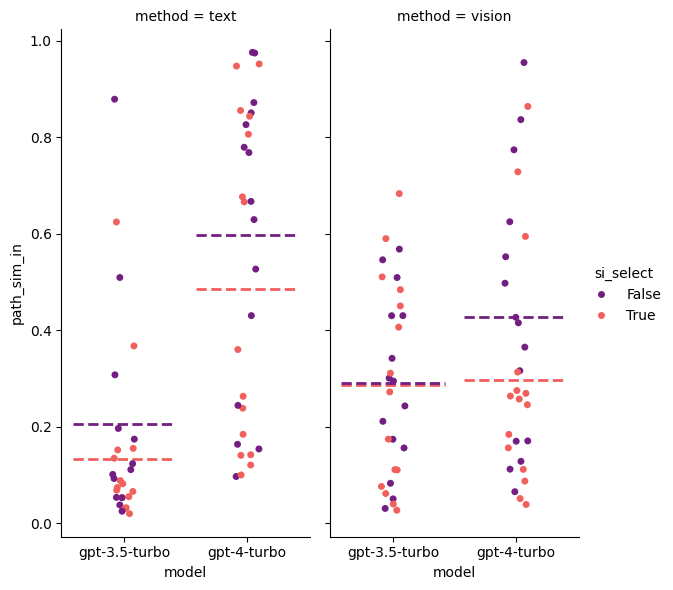

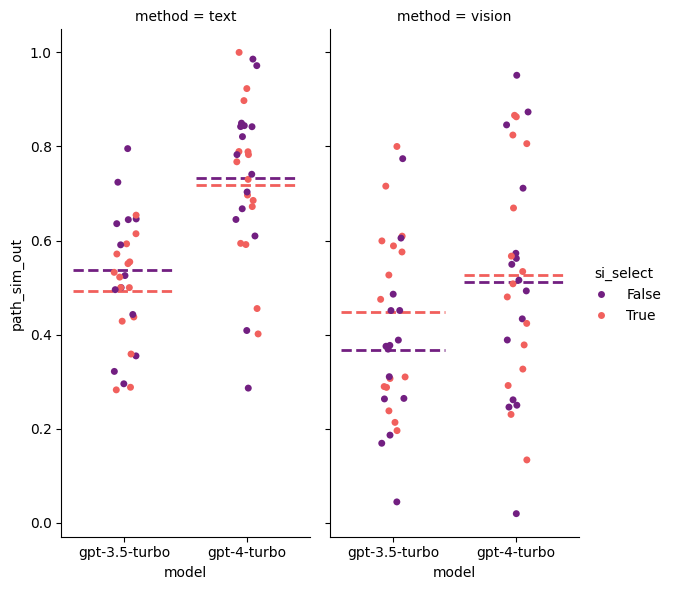

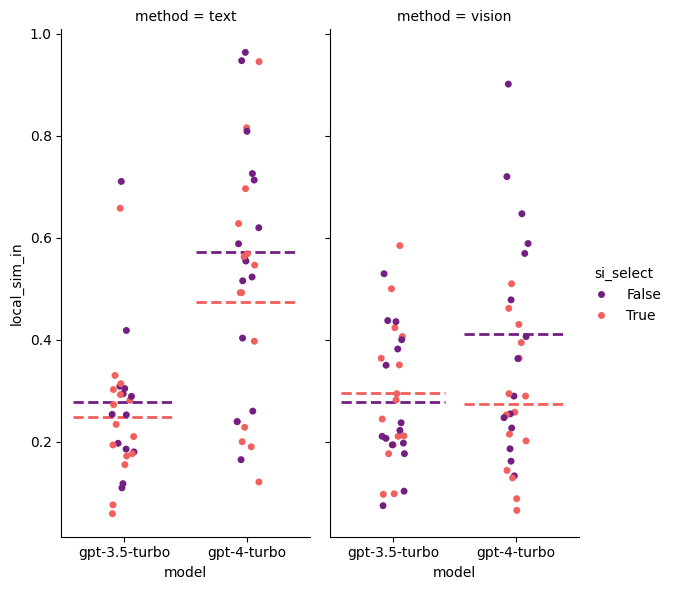

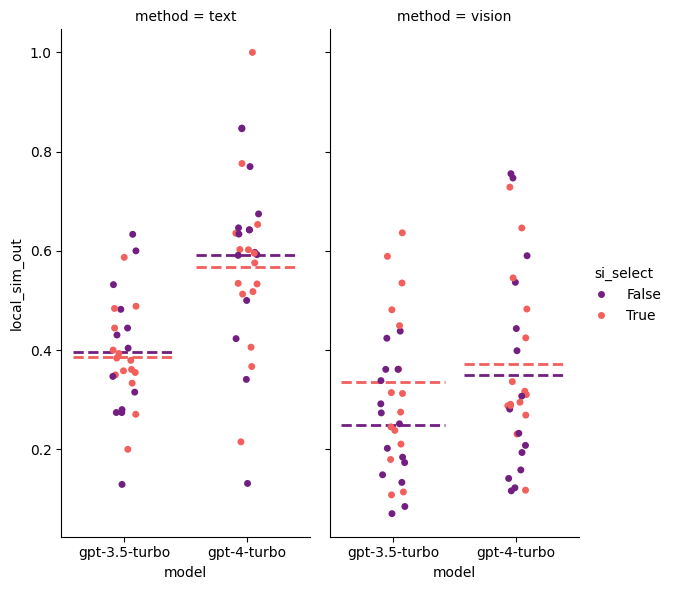

In [24]:
for m in ['path_sim_in', 'path_sim_out', 'local_sim_in', 'local_sim_out']:
    make_plot(m)

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def extract_subgraph(graph, start_node):
    """Use BFS to find all nodes reachable from start_node."""
    reachable_nodes = set(nx.bfs_tree(graph, start_node))
    return graph.subgraph(reachable_nodes).copy()


def plot_graph(G):
    fig = plt.figure(figsize=(10, 7))
    pos = graphviz_layout(G, prog="dot")
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.show()


reach_sgs = SynthTree.get_reach_subgraphs(extracted_G)
print(len(reach_sgs))

# for g in reach_sgs.values():
#     if len(g) > 1:
#             plot_graph(g)
#             print(g.nodes)

68
